In [1]:
import pymysql
from sqlalchemy import create_engine 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import time

In [2]:
class TeamColor():
    def __init__(self):
        self.pkl = pd.read_pickle('pickles/owl_colors.pickle')

    def get_hex_color(self, team_full_name):
        '''
        parameters: str, team_full_name, (enter team's full name)
        '''
        for team in self.pkl.keys():
            fullName = self.pkl[team]['fullName']
            if fullName == team_full_name:
                mainColor = self.pkl[team]['secondaryColor']
                color_in_hex = self.pkl[team]['colors'][mainColor]['hex']
                pass
            else:
                pass
        return color_in_hex
    
    def get_rgb_color(self, team_full_name):
        '''
        parameters: team_full_name, (enter team's full name)
        '''
        for team in self.pkl.keys():
            fullName = self.pkl[team]['fullName']
            if fullName == team_full_name:
                mainColor = self.pkl[team]['secondaryColor']
                color_in_rgb = self.pkl[team]['colors'][mainColor]['rgb']
                pass
            else:
                pass
        return color_in_rgb

In [3]:
teamcolor = TeamColor().get_hex_color('New York Excelsior')
print(teamcolor)

#0F57EA


In [4]:
class TeamNameConverter():
    def __init__(self):
        self.pkl = pd.read_pickle('pickles/df_esports_team_id.pickle')
    
    def to_id(self, team_full_name):
        '''
        parameters: str, team_full_name (enter team's full name)
        '''
        team_id = int(self.pkl[self.pkl['team_name'] == team_full_name]['team_id'])

        return team_id

    def to_name(self, team_id):
        '''
        parameters: int, team_id (enter team's id)
        '''
        team_name = (self.pkl[self.pkl['team_id'] == team_id]['team_name']).values[0]

        return team_name

In [5]:
team_id = TeamNameConverter().to_id('New York Excelsior')
team_name = TeamNameConverter().to_name(4403)
print(team_id)
print(team_name)

4403
New York Excelsior


In [6]:
def get_ts_map_start_end(match_id=None): # get map start and end times from pickle
    '''
    parameters: match_id: int

    returns:    ts_match_start, ts_map_start, ts_map_end (int, pandas.Series, pandas.Series)
    '''
    # get map start and end time
    path = 'D:\owl-data\pickles'
    file_name = 'OWL_map_start_info'
    timestamps = pd.read_pickle(os.path.join(path, file_name))

    # send error msg if there is no match_id
    if timestamps['esports_match_id'].isin([match_id]).any() == False:
        raise ValueError('there is no match_id in OWL_map_start_info')

    timestamps = timestamps[timestamps['esports_match_id'] == match_id]
    timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
    ts_match_start = timestamps['time_gamestart'].min()

    ts_map_start = timestamps['time_gamestart']
    ts_map_start.reset_index(drop=True, inplace=True)
    ts_map_end = timestamps['time_gameresult']
    ts_map_end.reset_index(drop=True, inplace=True)
    
    return ts_match_start, ts_map_start, ts_map_end

In [7]:
def get_team_info(match_id=None):
    '''
    parameters: match_id: int

    returns:    team_one_name, team_one_id, team_two_name, team_two_id (str, int, str, int)
    '''
    # get team_names
    path = 'D:\owl-data'
    file_name = 'OWL_match_results.csv'
    match_results = pd.read_csv(os.path.join(path, file_name))
    match_results = match_results[match_results['esports_match_id'] == match_id][['team_one_name', 'team_two_name']]
    match_results.reset_index(inplace=True)
    team_one_name = match_results.loc[0, 'team_one_name']
    team_two_name = match_results.loc[0, 'team_two_name']
    
    # get team_ids
    esports_team_id = pd.read_pickle(os.path.join('D:\owl-data\pickles', 'df_esports_team_id.pickle'))
    team_one_id = int(esports_team_id[esports_team_id['team_name'] == team_one_name]['team_id'])
    team_two_id = int(esports_team_id[esports_team_id['team_name'] == team_two_name]['team_id'])

    return team_one_name, team_one_id, team_two_name, team_two_id

In [8]:
def get_map_info(match_id=None):
    '''
    parameters: match_id: int

    returns:    map names (series)
    '''
    # get team_names
    path = 'D:\owl-data'
    file_name = 'OWL_match_results.csv'
    match_results = pd.read_csv(os.path.join(path, file_name))
    match_results = match_results[match_results['esports_match_id'] == match_id][['map_name']]
    match_results.reset_index(inplace=True)
    map_names = match_results['map_name']
    
    return map_names

In [9]:
# Get event timestamps
def getEvents(match_id=None, ssg=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=0):
    '''
    parameters: match_id: {esports_match_id} (int)
                ssg: {short_stat_guid} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)
                interval: '2S' (str), time interval to resample the data

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    dbname = "esd_phs"
    charset = "utf8"

    # Create connection to MySQL DB
    conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
    cur = conn.cursor()

    # send query
    table_id = f'match_{match_id}'

    if team_id == 0: # default
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' ORDER BY `time`;"
    else: # where designated team_id
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' AND `esports_team_id` = '{team_id}' ORDER BY `time`;"

    df = pd.read_sql(sql, conn)

    cur.close()
    conn.close()

    # get map start and end time in ms
    ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)

    # get map start times and end times
    map_start_times = ts_map_start - ts_match_start # set match start time as 0
    map_end_times = ts_map_end - ts_match_start # set match start time as 0

    # groupby df
    df2 = df[['time', 'short_stat_guid', 'amount', 'stat_category', 'battletag', 'esports_team_id']]
    df2['time'] = pd.to_numeric(df2['time'])
    df2['time'] = df2['time'] / 1000 # ms to s
    df2['time'] = df2['time'] - ts_match_start # set match start time as 0

    sum_df = df2.groupby(['time', 'short_stat_guid'])[['amount']].sum()

    # remove weired peak data
    for t in map_end_times:
        sum_df.drop(t, level='time', axis=0, inplace=True) # remove weired peak data at the endtime of maps
    
    sum_df = sum_df.droplevel(level='short_stat_guid')
    sum_df = sum_df.reset_index(level='time')
    sum_df['dx'] = sum_df['amount'].diff()
    sum_df['dt'] = sum_df['time'].diff()
    sum_df['dx/dt'] = sum_df['dx'] / sum_df['dt']
    
    # define event time with threshold
    sum_df['event'] = sum_df['dx'] > threshold # True if dx > threshold
    
    # transform time (int) into UTC datetime
    sum_df['time'] += ts_match_start
    sum_df['time'] = pd.to_datetime(sum_df['time'], unit='s', utc=True)
    
    # resample
    # sum_df = sum_df.resample(interval, on='time').sum()

    return sum_df

In [97]:
def getEvents_alives(match_id=None, team_id=None, stat_lifespan='ROUND', target_hero='no match'):
    '''
    parameters: match_id: {esports_match_id} (int)
                ssg: {short_stat_guid} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)
                interval: '2S' (str), time interval to resample the data

    returns:    dataframe, (pandas.DataFrame[['time', 'amount']])
    '''
    def import_esd(match_id=match_id, dbname="esd_phs", stat_lifespan='GAME', stat_category='Hero', **kwargs):
        '''
        parameters: match_id
                    kwargs: ['index', 'time', 'hero_guid', 'stat_lifespan', 'hero_name', 'short_stat_guid', 'amount', 'stat_name', 'stat_category', 'battletag', 'esports_player_id', 'esports_team_id']
        
        returns:    pd.DataFrame from MySQL DB
        '''
        # get sql from parameters
        table_id = f'match_{match_id}'
        sql = f"SELECT * FROM `{table_id}` WHERE `stat_lifespan` = '{stat_lifespan}' AND `stat_category` = '{stat_category}'"
        
        if len(kwargs) != 0:
            for name, value in kwargs.items():
                sql = sql + f" AND `{name}` = '{value}'"
        sql = sql + " ORDER BY `time`;"
        print(sql)

        # Credentials to DB connection
        hostname = "localhost" 
        username = "root"
        pwd = "gpdlzjadh"
        dbname = dbname #"esd_phs"
        charset = "utf8"

        # Create connection to MySQL DB
        conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
        cur = conn.cursor()

        # send query
        df = pd.read_sql(sql, conn)

        cur.close()
        conn.close()

        # preprocess dataframe
        # convert `time` column type from str to datetime
        df['time'] = df['time'].astype(float)
        df['time'] = df['time'] / 1000 # ms to s
        df['time'] = pd.to_datetime(df['time'], unit='s', utc=True)
        
        df['battletag'] = df['battletag'].str.split('#').str[0] # drop str after '#' in `battletag`
        df.drop(['index'], axis=1, inplace=True)
        df.set_index('time', inplace=True) # set 'time' column as index

        # slice only map played timeline
        # get map start and end time in ms
        ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)
        esd_tf = pd.DataFrame()
        for idx in ts_map_start.index:
            start, end = to_datetime(ts_map_start.loc[idx]), to_datetime(ts_map_end.loc[idx])
            df_tmp = df[start:end]
            df_tmp['map_order'] = idx + 1
            
            esd_tf = pd.concat([esd_tf, df_tmp], ignore_index=False) # index:datetime
        
        return esd_tf

    ###
    # get 1137 (time alive, no match)
    time_alive = import_esd(match_id=match_id, short_stat_guid=1137, esports_team_id=team_id) # 1133: each hero, 1137: no match
    grouping = ['time', 'battletag', 'hero_name']
    time_alive = time_alive.groupby(by=grouping).max()['amount']
    
    # diff()
    dx = time_alive.groupby(level=[x for x in list(time_alive.index.names) if x != 'time']).diff().fillna(time_alive) # fill nan as first value

    # define alive (time alive > 0) and not alive (time alive == 0)
    events_alives = dx>0

    # sum player's amount
    events_alives = events_alives.groupby(by='time').sum()

    # transform to [['time', 'amount']]
    events_alives = events_alives.reset_index()
    events_alives = events_alives[['time', 'amount']]

    return events_alives

In [11]:
def getEvents_teampowerbalance(match_id=None, stat_lifespan='ROUND', target_hero='no match'):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}

    returns:    events_teampowerbalance (pandas.DataFrame[['time', 'amount_{team_one}', 'amount_{team_two}', 'TPB']])
    '''
    # get team info
    team_one_name, team_one_id, team_two_name, team_two_id = get_team_info(match_id=match_id)

    team_one_alives = getEvents_alives(match_id=match_id, team_id=team_one_id)
    team_one_alives.rename(columns={'amount':'Alives'}, inplace=True)
    team_two_alives = getEvents_alives(match_id=match_id, team_id=team_two_id)
    team_two_alives.rename(columns={'amount':'Alives'}, inplace=True)
    events_teampowerbalance = team_one_alives.merge(team_two_alives, how='outer', on='time', suffixes=(f'_{team_one_name}', f'_{team_two_name}'))
    events_teampowerbalance['TPB'] = (events_teampowerbalance[f'Alives_{team_one_name}'] * events_teampowerbalance[f'Alives_{team_one_name}']) - (events_teampowerbalance[f'Alives_{team_two_name}'] * events_teampowerbalance[f'Alives_{team_two_name}'])

    return events_teampowerbalance

In [12]:
def getEvents_finalblows(match_id=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=0):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # short_stat_guid
    ssg = 44

    # get df
    sum_df = getEvents(match_id=match_id, ssg=ssg, stat_lifespan=stat_lifespan, target_hero=target_hero, team_id=team_id, threshold=threshold)

    return sum_df

In [13]:
def getEvents_herodamagedone(match_id=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=400):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 400 (float)

    returns:    event_alldamagedone (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # short_stat_guid
    ssg = 1208 # Hero_Damage_Done

    # get df
    sum_df = getEvents(match_id=match_id, ssg=ssg, stat_lifespan=stat_lifespan, target_hero=target_hero, team_id=team_id, threshold=threshold)

    return sum_df

In [14]:
def to_datetime(time):
    '''
    parameters: time: UTC timestamp in second(int)

    returns:    pd. datetime in seconds, UTC
    '''
    t = pd.to_datetime(time, unit='s', utc=True)

    return t

In [15]:
# TF detector
def TF_detector(df_rolling):
    '''
    parameters: dataframe
    <시작 조건>
    시작 조건 0. TF 중 = False
    시작 조건 1. time > 이전 TF 종료 시간
    시작 조건 2. HDD >= {HDD_threshold=500} (time - )
    시작 조건 3. FB > 0, time - {possible_time_variance=1}
    시작 조건 4. HDD >= {HDD_threshold=500} 시간 이후, first FB=False 상태로 HDD < {HDD_lull_cut=50} 생기면 이전 HDD time 제외

    <종료 조건>
    종료 조건 0. TF 진행 중 = True
    종료 조건 1. FB = 0 이 {no_FB_duration=10}초 이상
    종료 조건 2. time = ts_map_end_time

    *stagger
    *길어지는 한타
    FB 0 되고 10s동안 추가 킬이 없어야 한타 종료로 인정

    return:     TF_timestamps: dataframe of [['match_id', 'map_num', 'TF_start_time_stamps', 'TF_end_time_stamps']]
    '''
    global is_TF_ongoing
    is_TF_ongoing = False
    global FB_happened
    FB_happened = False
    global FB_silence
    FB_silence = False

    TF_start_time_stamps = []
    TF_end_time_stamps = []

    HDD_threshold = 500
    HDD_lull_cut = 500
    FB_threshold = 0
    possible_time_variance = 2
    no_FB_duration = 10

    # start condition
    def TF_start(idx):
        global is_TF_ongoing
        global FB_happened
        global FB_silence
        
        def condition0(): # TF 중 = False
            global is_TF_ongoing
            if is_TF_ongoing == True:
                cond0 = False
            else:
                cond0 = True
            return cond0

        def condition1(idx): # time > 이전 TF 종료 시간
            if (idx < df_rolling.index[-1]) == True:
                cond1 = True
            else:
                cond1 = False
            return cond1

        def condition2(idx): # HDD >= {HDD_threshold}
            if df_rolling.loc[idx, 'HDD'] > HDD_threshold:
                cond2 = True
            else:
                cond2 = False
            return cond2 
        
        def condition3(idx): # FB > 0
            global FB_happened
            if df_rolling.loc[idx, 'FB'] > FB_threshold:
                cond3 = True
                FB_happened = True # toggle on
            else:
                cond3 = False
            return cond3
        
        def condition4(idx): # HDD가 오르는 추세에 있어야
            if (df_rolling.loc[idx - pd.to_timedelta(no_FB_duration, unit='s') : idx, 'HDD'].mean() <= df_rolling.loc[idx : idx + pd.to_timedelta(no_FB_duration, unit='s'), 'HDD'].mean()) == True:
                cond4 = True
            else:
                cond4 = False
            return cond4 
        
        def condition5(idx): # HDD 가 {no_FB_duration} 범위에서 최소값일 경우
            if (df_rolling.loc[idx, 'HDD'] <= df_rolling.loc[idx : idx + pd.to_timedelta(no_FB_duration, unit='s'), 'HDD'].min()) == True:
                cond5 = True
            else:
                cond5 = False
            return cond5 


        # check if start_condition == True
        start_condition = condition0() & condition1(idx) & ( (condition2(idx) & condition4(idx) & condition5(idx)) | condition3(idx) ) 
        
        if start_condition == True:
            is_TF_ongoing = True # toggle on
            FB_silence = False # toggle off

        return is_TF_ongoing
    
    # end condition
    def TF_end(idx):
        global is_TF_ongoing
        global FB_happened
        global FB_silence

        def condition0(): # TF 진행 중 = True
            global is_TF_ongoing
            if is_TF_ongoing == True:
                cond0 = True
            else:
                cond0 = False 
            return cond0

        def condition1(idx): # FB = 0 이 {no_FB_duration}초 이상 유지될 때
            global FB_silence
            if df_rolling.loc[idx: idx + pd.to_timedelta(no_FB_duration, unit='s'), 'FB'].sum() == 0:
                cond1 = True 
                FB_silence = True # toggle on
            else:
                cond1 = False
            return cond1 
        
        def condition2(idx): # time = ts_map_end_time (Map이 종료됐을 때)
            if idx == df_rolling.index[-1]:
                cond2 = True
            else:
                cond2 = False
            return cond2
        
        def condition3(idx): # FB > 0
            global FB_happened
            if df_rolling.loc[idx, 'FB'] > FB_threshold:
                cond3 = True
                FB_happened = True # toggle on
            else:
                cond3 = False
            return cond3
        
        def condition4(idx): # while FB == 0 & HDD <= {HDD_lull_cut}
            if (df_rolling.loc[idx, 'FB'] == 0) & (df_rolling.loc[idx, 'HDD'] <= HDD_lull_cut):
                cond4 = True
            else:
                cond4 = False
            return cond4
        
        def condition5(idx): # 2s 동안 mean(HDD) < HDD_threshold 
            if df_rolling.loc[idx:idx + pd.to_timedelta(2, unit='s'), 'HDD'].mean() < HDD_threshold:
                cond5 = True
            else:
                cond5 = False
            return cond5

        # init FB_happened
        condition3(idx)

        # check if end_condition == True
        end_condition = ( condition0() & ((condition1(idx) & condition5(idx)) & FB_happened) | (FB_happened & condition4(idx)) ) | condition2(idx)

        if end_condition == True:
            is_TF_ongoing = False # toggle off
            FB_happened = False # toggle off

        return is_TF_ongoing

    TF_status = []

    for idx in df_rolling.index:
        if is_TF_ongoing == False:
            TF_status.append(TF_start(idx))
        else:
            TF_status.append(TF_end(idx))

    df_rolling['TF_status'] = TF_status

    return df_rolling # [['TPB', 'HDD', 'FB', 'TF_status']], index=UTC timestamp

In [16]:
# get TF_time_range
def get_true_range(df=None, column='TF_status'):
    '''
    parameters: data: dataframe with timestamp index
                column: target column to arrange
    
    returns:    index tuple
    '''
    range_list = []
    prev_val = False

    for inx, val in df[column].iteritems():
        if prev_val != val:
            if val:
                start = inx
            else:
                range_list.append((start, inx))

        prev_inx = inx
        prev_val = val
    
    return range_list

In [17]:
def get_esports_match_ids(team_name='All', opponent_name='All', winner='All', loser='All', season='All', map_name='All'):
    '''
    parameters: team_name: target team name
                opponent_name: opponent team name
                winner: winner team name
                loser: loser team name
                season: 2018, 2019, 2020
                map: map name
                period: datetime range e.g.('2020-08-01':'2020-09-01')
    
    returns:    esports_match_ids
    '''
    df = pd.read_csv(os.path.join('D:\owl-data', 'OWL_match_results.csv'))

    # df1 (search team_name)
    if team_name == 'All':
        df1 = df
    else:
        df1 = pd.concat([df[df['team_one_name'].str.contains(team_name)], df[df['team_two_name'].str.contains(team_name)]])
    
    # df2 (search opponent_name)
    if opponent_name == 'All':
        df2 = df1
    else:
        df2 = pd.concat([df1[df1['team_one_name'].str.contains(opponent_name)], df1[df1['team_two_name'].str.contains(opponent_name)]]) 
    
    # df3 (search winner)
    if winner == 'All':
        df3 = df2
    else:
        df3 = df2[df2['match_winner'] == winner]
    
    # df4 (search loser): loser 검색 시에는 반드시 team_name or opponent_name 설정을 해줘야 함
    if loser == 'All':
        df4 = df3
    else:
        if team_name == 'All' & opponent_name == 'All':
            raise ValueError('define team_name or opponent_name first')
        else:
            df4 = df3[df3['match_winner'] != loser]
    
    # df5 (search season)
    if season == 'All':
        df5 = df4
    else:
        season_id = str(season - 2017) # 2018 = 1st season
        df5 = df4[df4['esports_match_id'].astype(str).str.startswith(season_id)]

    # df6 (search map_name)
    if map_name == 'All':
        df6 = df5
    else:
        df6 = df5[df5['map_name'].str.contains(map_name)]

    esports_match_ids = df6['esports_match_id'].unique()

    return esports_match_ids

## Get Teamfight timestamps and info

In [18]:
def get_teamfight_info(match_id=None, plotting=False, **kwargs):
    '''
    parameters:     match_id
                    plotting: plot graphs if True
                    *kwargs: item=['HDD', 'FB', 'TPB'] (maximum 2 of 3 items to plot. ex. ['HDD', 'FB'])

    returns:        dataframe of teamfight info
    '''
    # HDB, FB, TPB
    stat_lifespan = 'GAME'
    events_finalblows = getEvents_finalblows(match_id=match_id, stat_lifespan=stat_lifespan)
    events_herodamagedone = getEvents_herodamagedone(match_id=match_id, stat_lifespan=stat_lifespan)
    events_TPB = getEvents_teampowerbalance(match_id=match_id, stat_lifespan=stat_lifespan)

    # put all relevant stats into df_TF
    # TPB
    df1 = events_TPB[['time', 'TPB']]
    # HDD
    df2 = events_herodamagedone[['time', 'dx']]
    df2 = df2.rename(columns={'dx':'HDD'})
    # FB
    df3 = events_finalblows[['time', 'dx']]
    df3 = df3.rename(columns={'dx':'FB'})
    # merge
    df_TF = df1.merge(df2, how='outer', on='time')
    df_TF = df_TF.merge(df3, how='outer', on='time')
    # remove (-) values in HDD/s and FB (it appears when a map starts cuz 'dx' was calculated by diff())
    df_TF = df_TF[df_TF['HDD'] >= 0]
    df_TF = df_TF[df_TF['FB'] >= 0]

    # resampling to align timeline
    resample = df_TF.resample('2s', on='time').sum()

    # get df of rolling with moving window
    window = 5 # indicates 10 sec (window * 2 sec (Blizzard provides 2sec ESD sampling frequency))
    rolling = resample.rolling(window=window, center=True, min_periods=1).sum() # sum rolling windows with min_periods=1

    # get map info
    map_names = get_map_info(match_id=match_id)

    # get team info
    team_one_name, team_one_id, team_two_name, team_two_id = get_team_info(match_id=match_id)
    
    # match start timestamps
    ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)
    ts_match_start = pd.to_datetime(ts_match_start, unit='s', utc=True)

    # get df of teamfight info
    df_TF_match = pd.DataFrame()

    for m in map_names.index:
        df_map = rolling[to_datetime(ts_map_start[m]): to_datetime(ts_map_end[m])]
        df_map = TF_detector(df_map)
        TF_time_range = get_true_range(df_map)


        # get teamfight info by maps
        df_TF_map = pd.DataFrame(TF_time_range, columns=['TF_start_datetime', 'TF_end_datetime'])
        df_TF_map['esports_match_id'] = match_id
        df_TF_map['map_name'] = map_names[m]
        df_TF_map['map_order'] = m + 1
        
        # define TF winner and TPB
        TF_winner_list = []
        TF_order_list = []
        TF_duration_list = []
        TF_TPB_list = []
        TF_TPBps_list = [] # TPB/s
        TF_order = 0
        
        for idx in df_TF_map.index:
            TF_order += 1
            TF_order_list.append(TF_order)
            TF_duration_list.append((df_TF_map.loc[idx, 'TF_end_datetime'] - df_TF_map.loc[idx, 'TF_start_datetime']).seconds) # TF duration in s
            TF_TPB_sum = df_map.loc[df_TF_map.loc[idx, 'TF_start_datetime']:df_TF_map.loc[idx, 'TF_end_datetime'], 'TPB'].sum()
            TF_TPB_list.append(TF_TPB_sum) # TPB
            TF_TPBps_list.append(TF_TPB_sum / ((df_TF_map.loc[idx, 'TF_end_datetime'] - df_TF_map.loc[idx, 'TF_start_datetime']).seconds)) # TPB / s
            if TF_TPB_sum > 0:
                TF_winner_list.append(team_one_name)
            elif TF_TPB_sum == 0:
                TF_winner_list.append('draw')
            else:
                TF_winner_list.append(team_two_name)
        df_TF_map['TF_order'] = TF_order_list
        df_TF_map['TF_winner'] = TF_winner_list
        df_TF_map['TF_duration'] = TF_duration_list
        df_TF_map['TF_TPB_sum'] = TF_TPB_list
        df_TF_map['TF_TPB_sum/s'] = TF_TPBps_list

        # plot if plotting == True
        fig_opt={'figsize':(20,10), 'linewidth':1, 'color_TF_shading':'gray', 'color_HDD':'green', 'color_FB':'red', 'color_TPB':'black'}
        if plotting == True:
            figsize = fig_opt['figsize']
            linewidth = fig_opt['linewidth']
            color_TF_shading = fig_opt['color_TF_shading']
            color_HDD = fig_opt['color_HDD']
            color_FB = fig_opt['color_FB']
            color_TPB = fig_opt['color_TPB']

            plt.figure(figsize=figsize)

            plt.title(f'{match_id}_{team_one_name} vs {team_two_name} in {map_names[m]}')

            pitem = kwargs['item'] # get plotting items
            if len(pitem) == 1: # only one item
                # set line color
                if 'HDD' in pitem == True:
                    color = color_HDD
                elif 'FB' in pitem == True:
                    color = color_FB 
                elif 'TPB' in pitem == True:
                    color = color_TPB 
                
                sns.lineplot(x='time', y=pitem, data=df_map, color=color, linewidth=linewidth)  
                plt.ylabel(pitem)
            
            elif len(pitem) > 1:
                # set line color
                if pitem[0] == 'HDD':
                    color0 = color_HDD
                elif pitem[0] == 'FB':
                    color0 = color_FB 
                elif pitem[0] == 'TPB':
                    color0 = color_TPB 

                if pitem[1] == 'HDD':
                    color1 = color_HDD
                elif pitem[1] == 'FB':
                    color1 = color_FB 
                elif pitem[1] == 'TPB':
                    color1 = color_TPB 

                ax = sns.lineplot(x='time', y=pitem[0], data=df_map, color=color0, linewidth=linewidth)
                plt.ylabel(pitem[0])
                ax1 = ax.twinx()
                sns.lineplot(x='time', y=pitem[1], data=df_map, color=color1, ax=ax1, linewidth=linewidth)
                plt.ylabel(pitem[1])
            
            elif len(pitem) > 2:
                raise ('Too many items to plot')

            
            # plot shading during teamfight
            for (start, end) in TF_time_range:
                plt.axvspan(start, end, color=color_TF_shading, alpha=0.5)

            plt.xlim(to_datetime(ts_map_start[m]), to_datetime(ts_map_end[m]))
            plt.show()

        # concat into df_TF_match
        df_TF_match = pd.concat([df_TF_match, df_TF_map], ignore_index=True)
        
    
    return df_TF_match

In [ ]:
# plotting teamfight
df_ = get_teamfight_info(match_id=match_id, plotting=True, item=['HDD', 'TPB'])

## Save and Export to csv

In [ ]:
# save df as csv in results folder

match_ids = pd.read_csv('OWL_match_results.csv')['esports_match_id'].unique()

for match_id in match_ids:
    try:
        df_ = get_teamfight_info(match_id=match_id, plotting=False)
        df_.to_csv('results/tf_info'+f'{match_id}.csv')
    except:
        print(f'not in mysql: {match_id}')

## Cleansing

In [19]:
class Match:
    def __init__(self, match_id=None):
        self.match_id = match_id
        self.set_match_result_summary()
        self.set_match_variables()

    def set_match_result_summary(self):
        '''
        requirements:   'OWL_match_results.csv'
        '''
        path = 'D:\owl-data'
        file_name = 'OWL_match_results.csv'
        match_result_summary = pd.read_csv(os.path.join(path, file_name))
        match_result_summary = match_result_summary[match_result_summary['esports_match_id'] == self.match_id]
        match_result_summary.reset_index(inplace=True)
        match_result_summary = match_result_summary[['start_time', 'esports_match_id', 'map_name', 'team_one_name', 'team_two_name', 'match_winner', 'map_winner', 'winning_team_final_map_score', 'losing_team_final_map_score']]

        self.match_result_summary = match_result_summary
    
    def get_match_result_summary(self):
        return self.match_result_summary

    def set_match_variables(self):
        '''
        requirements:   'df_esports_team_id.pickle', 'OWL_map_start_info'
        '''
        # team_names
        self.team_names = [self.match_result_summary['team_one_name'][0], self.match_result_summary['team_two_name'][0]]
        # match_winner_name
        self.match_winner_name = self.match_result_summary['match_winner'][0]
        # match_loser_name
        for team in self.team_names:
            if team == self.match_winner_name:
                pass 
            else: 
                self.match_loser_name = team
        # team_ids
        esports_team_id = pd.read_pickle(os.path.join('D:\owl-data\pickles', 'df_esports_team_id.pickle'))
        self.team_ids = [int(esports_team_id[esports_team_id['team_name'] == self.team_names[0]]['team_id']), int(esports_team_id[esports_team_id['team_name'] == self.team_names[1]]['team_id'])]
        self.match_winner_id = int(esports_team_id[esports_team_id['team_name'] == self.match_winner_name]['team_id'])
        self.match_loser_id = int(esports_team_id[esports_team_id['team_name'] == self.match_loser_name]['team_id'])
        # box score
        self.box_score_winner = sum(self.match_result_summary['map_winner'] == self.match_winner_name)
        self.box_score_loser = sum(self.match_result_summary['map_winner'] == self.match_loser_name)
        # time info
        def get_ts_map_start_end(match_id=None): # get map start and end times from pickle
            '''
            parameters: match_id: int

            returns:    ts_match_start, self.ts_map_start, ts_map_end (int, pandas.Series, pandas.Series)
            '''
            # get map start and end time
            path = 'D:\owl-data\pickles'
            file_name = 'OWL_map_start_info'
            timestamps = pd.read_pickle(os.path.join(path, file_name))

            # send error msg if there is no match_id
            if timestamps['esports_match_id'].isin([match_id]).any() == False:
                raise ValueError('there is no match_id in OWL_map_start_info')

            timestamps = timestamps[timestamps['esports_match_id'] == match_id]
            timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
            ts_match_start = timestamps['time_gamestart'].min()

            ts_map_start = timestamps['time_gamestart']
            ts_map_start.reset_index(drop=True, inplace=True)
            ts_map_end = timestamps['time_gameresult']
            ts_map_end.reset_index(drop=True, inplace=True)
            
            return ts_match_start, ts_map_start, ts_map_end
        self.ts_match_start, self.ts_map_start, self.ts_map_end = get_ts_map_start_end(match_id=self.match_id)


    def import_esd(self, dbname="esd_phs", stat_lifespan='GAME', stat_category='Hero', **kwargs):
        '''
        parameters: match_id
                    kwargs: ['index', 'time', 'hero_guid', 'stat_lifespan', 'hero_name', 'short_stat_guid', 'amount', 'stat_name', 'stat_category', 'battletag', 'esports_player_id', 'esports_team_id']
        
        returns:    pd.DataFrame from MySQL DB
        '''
        # get sql from parameters
        table_id = f'match_{self.match_id}'
        sql = f"SELECT * FROM `{table_id}` WHERE `stat_lifespan` = '{stat_lifespan}' AND `stat_category` = '{stat_category}'"
        
        if len(kwargs) != 0:
            for name, value in kwargs.items():
                sql = sql + f" AND `{name}` = '{value}'"
        sql = sql + " ORDER BY `time`;"
        print(sql)

        # Credentials to DB connection
        hostname = "localhost" 
        username = "root"
        pwd = "gpdlzjadh"
        dbname = dbname #"esd_phs"
        charset = "utf8"

        # Create connection to MySQL DB
        conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
        cur = conn.cursor()

        # send query
        df = pd.read_sql(sql, conn)

        cur.close()
        conn.close()

        # preprocess dataframe
        # convert `time` column type from str to datetime
        df['time'] = df['time'].astype(float)
        df['time'] = df['time'] / 1000 # ms to s
        df['time'] = pd.to_datetime(df['time'], unit='s', utc=True)
        
        df['battletag'] = df['battletag'].str.split('#').str[0] # drop str after '#' in `battletag`
        df.drop(['index'], axis=1, inplace=True)
        df.set_index('time', inplace=True) # set 'time' column as index

        # slice only map played timeline
        esd_tf = pd.DataFrame()
        for idx in self.ts_map_start.index:
            start, end = to_datetime(self.ts_map_start.loc[idx]), to_datetime(self.ts_map_end.loc[idx])
            df_tmp = df[start:end]
            df_tmp['map_order'] = idx + 1
            
            esd_tf = pd.concat([esd_tf, df_tmp], ignore_index=False) # index:datetime
        
        return esd_tf

In [20]:
class Teamfight(Match):
    def __init__(self, match_id=None):
        self.match_id = match_id
        self.set_match_result_summary()
        self.set_match_variables()
    
    def get_TF_trends(self, short_stat_guid=None, map_order=1):
        '''
        paramters:  match_id:  
                    short_stat_guid:
                    map_order:
        
        returns:    dataframe
        '''
        # get ESD from MySQL DB
        timeplayed = self.import_esd(short_stat_guid=33) # get timeplayed to set time-axis
        timeplayed = timeplayed[timeplayed['map_order'] == map_order]
        target_stat = self.import_esd(short_stat_guid=short_stat_guid)
        target_stat = target_stat[target_stat['map_order'] == map_order]

        # grouping
        group_timeplayed = timeplayed.groupby(by=['time', 'esports_team_id', 'battletag', 'hero_name'])[['amount']].mean()
        group_target_stat = target_stat.groupby(by=['time', 'esports_team_id', 'battletag', 'hero_name'])[['amount']].mean()

        # get amount, dx, dt, dx/dt
        df_merge = pd.merge(group_timeplayed, group_target_stat, how='outer', left_index=True, right_index=True, suffixes=('_timeplayed', '_target_stat'))
        # df_merge['amount_target_stat'].fillna(0, inplace=True) # initialize stat value

        df_merge['dx'] = df_merge.groupby(level=['esports_team_id', 'battletag', 'hero_name'])['amount_target_stat'].diff().fillna(df_merge['amount_target_stat']) # fill nan as first value
        df_merge['dt'] = df_merge['dx'].reset_index('time').groupby(level=['esports_team_id', 'battletag', 'hero_name'])['time'].diff().dt.seconds.values
        df_merge['dx/dt'] = df_merge['dx'].div(df_merge['dt'], axis=0)

        # reset index of esports_team_id
        df_merge.reset_index('esports_team_id', inplace=True)
        
        return df_merge


In [47]:
# match results
# set match_id, instance
match_id = 34912
match = Match(match_id)
# match winner and loser
match_winner_name = match.match_winner_name
match_loser_name = match.match_loser_name
# box scores
box_score = (match.box_score_winner, match.box_score_loser)
print(f'box score: {match_winner_name} {box_score[0]} vs {box_score[1]} {match_loser_name}')
# match result summary
match_result_summary = match.get_match_result_summary()
# match dashboard
# display(match.import_esd(short_stat_guid=44))
# TF
teamfight = Teamfight(match_id)
teamfight.get_TF_trends(short_stat_guid=1133).head(50)


box score: New York Excelsior 3 vs 2 Guangzhou Charge
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '1133' ORDER BY `time`;


Symmetra                4403.0   
                                    JJonak    Zenyatta                4403.0   
                                    Mano      Wrecking Ball           4403.0   
                                    Nenne     Ashe                    4403.0   
                                    anamo     Mercy                   4403.0   
                                    Chara     Lúcio                   7699.0   
                                    Cr0ng     Sigma                   7699.0   
                                    Eileen    Mei                     7699.0   
                                    Happy     Symmetra                7699.0   
                                    Rio       Reinhardt               7699.0   
                                    shu       Baptiste                7699.0   
2020-08-08 11:44:53.401000023+00:00 BiaNcA    Zarya                   4403.0   
                                    Haksal    Genji                   4403.0   
                                              Symmetra                4403.0   
                                    JJonak    Zenyatta                4403.0   
                                    Mano      Wrecking Ball           4403.0   
                                    Nenne     Ashe                    4403.0   
                                    anamo     Mercy                   4403.0   
                                    Chara     Lúcio                   7699.0   
                                    Cr0ng     Sigma                   7699.0   
                                    Eileen    Mei                     7699.0   
                                    Happy     McCree                  7699.0   
                                              Symmetra                7699.0   
                                    Rio       Reinhardt               7699.0   
                                    shu       Baptiste                7699.0   
2020-08-08 11:44:55.489000082+00:00 BiaNcA    Zarya                   4403.0   
                                    Haksal    Genji                   4403.0   
                                              Symmetra                4403.0   
                                    JJonak    Zenyatta                4403.0   
                                    Mano      Wrecking Ball           4403.0   
                                    Nenne     Ashe                    4403.0   
                                    anamo     Mercy                   4403.0   
                                    Chara     Lúcio                   7699.0   
                                    Cr0ng     Sigma                   7699.0   
                                    Eileen    Mei                     7699.0   
                                    Happy     McCree                  7699.0   
                                              Symmetra                7699.0   
                                    Rio       Reinhardt               7699.0   
                                    shu       Baptiste                7699.0   
2020-08-08 11:44:57.566999912+00:00 BiaNcA    Zarya                   4403.0   
                                    Haksal    Genji                   4403.0   
                                              Symmetra                4403.0   
                                    JJonak    Zenyatta                4403.0   
                                    Mano      Wrecking Ball           4403.0   
                                    Nenne     Ashe                    4403.0   
                                    anamo     Mercy                   4403.0   
                                    Chara     Lúcio                   7699.0   
                                    Cr0ng     Sigma                   7699.0   
                                    Eileen    Mei                     7699.0   

                                                             amount_timeplayed  \
time                                battlet

In [30]:
class StatReport(Match):
    # ssg_dict = {'Time Played':33, 'Final Blows':43}
    ssg_dict = {'Time Played':33, 'Final Blows':43, 'Deaths':42, 'Hero Damage Done':1207, 'Barrier Damage Done':1301, 'Hero Damage Taken':401, 'Healing Done':449, 'Healing Received': 1716, 'Ultimate Earned':1122, 'Ultimate Used':1123, 'Assists':1319, 'Solo Kills':45, 'Lives':1134}
    
    def __init__(self, match_id):
        self.match_id = match_id
        self.set_match_result_summary()
        self.set_match_variables()
        self.set_mode()
        self.set_category()
        self.set_grouping()
        self.set_ssg_dict()
        self.set_tf_time()
        self.set_trends()
        self.set_TPB()

    def set_mode(self, mode='match'):
        '''
        parameters: str, {'match', 'map', 'teamfight'}, default: 'match'
        '''
        self.mode = mode

    def set_category(self, category='team'):
        '''
        parameters: str, {'team', 'player'}, default: 'team'
        '''
        self.category = category
    
    def set_grouping(self, grouping=['map_order', 'time', 'esports_team_id', 'battletag', 'hero_name']):
        '''
        parameters: list, default:['map_order', 'time', 'esports_team_id', 'battletag', 'hero_name']
        '''
        self.grouping = grouping 

    def set_ssg_dict(self, ssg_dict=ssg_dict):
        '''
        parameters: ssg_dict, dictionary, StatReport.ssg_dict
        '''
        self.ssg_dict = ssg_dict
    
    def set_tf_time(self, buffer_time=2):
        '''
        requirements:   'results/tf_info/{self.match_id}.csv'
        parameters:     buffer_time (in seconds), default:2
        '''
        # import TF info
        tf_timeline = pd.read_csv(os.path.join('results/tf_info', f'{self.match_id}.csv'))
        tf_timeline['TF_start_datetime'] = pd.to_datetime(tf_timeline['TF_start_datetime'], format='%Y-%m-%d %H:%M:%S') - pd.to_timedelta(buffer_time, unit='s') # time - buffer_time
        tf_timeline['TF_end_datetime'] = pd.to_datetime(tf_timeline['TF_end_datetime'], format='%Y-%m-%d %H:%M:%S') + pd.to_timedelta(buffer_time, unit='s') # time + buffer_time

        self.tf_timeline = tf_timeline

    def set_trends(self):
        '''
        set match stat trends of all players with 'ssg_dict'
        '''
        df_trends = self.import_esd(short_stat_guid=33).groupby(by=self.grouping)[['amount']].max() # set index as timeplayed (ssg=33)

        for stat_name, ssg in self.ssg_dict.items():
            df = self.import_esd(short_stat_guid=ssg).groupby(by=self.grouping)[['amount']].max() # get agg stat
            df.rename(columns={'amount':f'{stat_name}'}, inplace=True) # rename column to stat_name
            df_trends = pd.merge(df_trends, df, how='outer', left_index=True, right_index=True).fillna(0)
        
        df_trends.drop(columns='amount', inplace=True) # drop 'amount' column

        # get 'All Heroes' sum
        hero_sum = df_trends.groupby(by=self.grouping[:-1]).sum() # sum all heroes amounts
        hero_sum['hero_name'] = 'All Heroes'
        hero_sum = hero_sum.groupby(by=self.grouping).max()
        df_trends = pd.concat([df_trends, hero_sum], axis=0)
        df_trends = df_trends.groupby(by=self.grouping).max()

        # get amount, dx, dt, dx/dt
        dx = df_trends.groupby(level=['map_order', 'esports_team_id', 'battletag', 'hero_name']).diff().fillna(df_trends) # fill nan as first value
        dt = dx.reset_index('time').groupby(level=['map_order', 'esports_team_id', 'battletag', 'hero_name'])['time'].diff().dt.seconds.values
        dxdt = dx.div(dt, axis=0)

        df_trends = pd.merge(df_trends, dx, left_index=True, right_index=True, suffixes=('', '_dx'))
        df_trends = pd.merge(df_trends, dxdt, left_index=True, right_index=True, suffixes=('', '_dx/dt'))

        self.df_trends = df_trends
    
    def get_trends(self):
        return self.df_trends 

    # get TPB
    def set_TPB(self):
        '''
        match winner's TPB will be positive side
        '''
        TPB = getEvents_teampowerbalance(self.match_id, stat_lifespan='GAME')
        TPB = TPB.set_index('time')
        if TPB.columns[0].split('_')[1] == self.match_winner_name: # make match winner's TPB as positive values
            pass
        else:
            TPB['TPB'] = TPB['TPB'] * (-1) # make match winner's TPB as positive values

        self.TPB = TPB

        df_tf_TPB = pd.DataFrame()
        for idx in self.tf_timeline.index:
            start, end = self.tf_timeline.loc[idx, 'TF_start_datetime'], self.tf_timeline.loc[idx, 'TF_end_datetime']
            df_tmp = self.TPB
            df_tmp = df_tmp.loc[start:end] # slice 'time' index
            df_tmp['map_name'] = self.tf_timeline.loc[idx, 'map_name']
            df_tmp['map_order'] = self.tf_timeline.loc[idx, 'map_order'] # already involved in self.df_trends
            df_tmp['TF_order'] = self.tf_timeline.loc[idx, 'TF_order']
            df_tmp['TF_winner'] = self.tf_timeline.loc[idx, 'TF_winner']
            df_tmp['TF_duration'] = self.tf_timeline.loc[idx, 'TF_duration']
            # df_tmp['TF_TPB_sum'] = self.tf_timeline.loc[idx, 'TF_TPB_sum']
            # df_tmp['TF_TPB_sum/s'] = self.tf_timeline.loc[idx, 'TF_TPB_sum/s']

            df_tf_TPB = pd.concat([df_tf_TPB, df_tmp], ignore_index=False) # index:datetime
        
        self.df_tf_TPB = df_tf_TPB        

    def get_TPB(self):
        '''
        returns self.TPB
        '''
        return self.df_tf_TPB

    def get_tf_trends(self):
        '''
        parameters:
        '''
        df_tf_trends = pd.DataFrame()
        for idx in self.tf_timeline.index:
            start, end = self.tf_timeline.loc[idx, 'TF_start_datetime'], self.tf_timeline.loc[idx, 'TF_end_datetime']
            df_tmp = self.df_trends.reset_index()
            df_tmp = df_tmp.set_index('time')
            df_tmp = df_tmp.loc[start:end] # slice 'time' index
            df_tmp = df_tmp.groupby(self.grouping).max()
            df_tmp['map_name'] = self.tf_timeline.loc[idx, 'map_name']
            # df_tmp['map_order'] = self.tf_timeline.loc[idx, 'map_order'] # already involved in self.df_trends
            df_tmp['TF_order'] = self.tf_timeline.loc[idx, 'TF_order']
            df_tmp['TF_winner'] = self.tf_timeline.loc[idx, 'TF_winner']

            df_tf_trends = pd.concat([df_tf_trends, df_tmp], ignore_index=False) # index:datetime
        df_tf_trends = df_tf_trends.groupby(by=['map_order', 'map_name', 'TF_order', 'TF_winner', 'time', 'esports_team_id', 'battletag', 'hero_name']).max()

        # merge TPB
        TPB = self.df_tf_TPB.groupby(by=['map_order', 'map_name', 'TF_order', 'TF_winner', 'time']).max() #[['TPB', 'TF_duration']]
        df_tf_trends = pd.merge(df_tf_trends, TPB, how='outer', left_index=True, right_index=True)

        return df_tf_trends

    def get_report_summary(self):
        '''
        set_mode({'map', 'match', 'teamfight'})
        set_category({'player', 'team'})

        returns:    dataframe
        '''
        mode = self.mode
        category = self.category
        ssg_dict = self.ssg_dict 

        first_ssg_name = list(ssg_dict)[0]
        last_ssg_name = list(ssg_dict)[-1]

        grouping = [x for x in list(self.df_trends.index.names) if x != 'time'] #['map_order', 'esports_team_id', 'battletag', 'hero_name']
        df_trends = self.df_trends.groupby(by=grouping).max()
        if mode == 'map':
            pass
        elif mode == 'match':
            grouping = [x for x in list(df_trends.index.names) if x != 'map_order'] #['esports_team_id', 'battletag', 'hero_name']
            df_trends = df_trends.groupby(by=grouping).sum() # grouping without 'map_order'
        elif mode == 'teamfight':
            df_tf_trends = self.get_tf_trends()
            tf_max = df_tf_trends.groupby(by=['map_order', 'map_name', 'TF_order', 'TF_winner', 'esports_team_id', 'battletag', 'hero_name']).max()
            tf_min = df_tf_trends.groupby(by=['map_order', 'map_name', 'TF_order', 'TF_winner', 'esports_team_id', 'battletag', 'hero_name']).min()
            df_trends = tf_max - tf_min

        if category == 'player':
            report_summary = df_trends.loc[:, first_ssg_name:last_ssg_name] # get max of each player
            pass
        
        elif category == 'team':
            report_summary = df_trends.xs('All Heroes', level='hero_name', drop_level=False) # slice 'All Heroes'
            index_names = list(report_summary.index.names)
            grouping = [x for x in index_names if x != 'battletag'] # remove 'battletag' from grouping
            report_summary = report_summary.groupby(by=grouping).sum().loc[:, first_ssg_name:last_ssg_name] # sum all players stats

        return report_summary


In [31]:
stat_report = StatReport(match_id)

display(stat_report.get_trends())

SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '43' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '42' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '1207' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '1301' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '401' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME

Time Played  \
map_order time                                esports_team_id battletag hero_name                 
1         2020-08-08 11:44:51.322999954+00:00 4403.0          BiaNcA    All Heroes     1.949440   
                                                                        Zarya          1.949440   
                                                              Haksal    All Heroes     0.974463   
                                                                        Symmetra       0.974463   
                                                              JJonak    All Heroes     0.974463   
...                                                                                         ...   
5         2020-08-08 13:18:32.634999990+00:00 7699.0          Rio       Winston      569.351000   
                                                              shu       All Heroes   631.660700   
                                                                        Ana          316.309000   
                                                                        Baptiste      64.257700   
                                                                        Moira        251.094000   

                                                                                    Final Blows  \
map_order time                                esports_team_id battletag hero_name                 
1         2020-08-08 11:44:51.322999954+00:00 4403.0          BiaNcA    All Heroes          0.0   
                                                                        Zarya               0.0   
                                                              Haksal    All Heroes          0.0   
                                                                        Symmetra            0.0   
                                                              JJonak    All Heroes          0.0   
...                                                                                         ...   
5         2020-08-08 13:18:32.634999990+00:00 7699.0          Rio       Winston             4.0   
                                                              shu       All Heroes          5.0   
                                                                        Ana                 0.0   
                                                                        Baptiste            0.0   
                                                                        Moira               5.0   

                                                                                    Deaths  \
map_order time                                esports_team_id battletag hero_name            
1         2020-08-08 11:44:51.322999954+00:00 4403.0          BiaNcA    All Heroes     0.0   
                                                                        Zarya          0.0   
                                                              Haksal    All Heroes     0.0   
                                                                        Symmetra       0.0   
                                                              JJonak    All Heroes     0.0   
...                                                                                    ...   
5         2020-08-08 13:18:32.634999990+00:00 7699.0          Rio       Winston        8.0   
                                                              shu       All Heroes     3.0   
                                                                        Ana            2.0   
                                                                        Baptiste       0.0   
                                                                        Moira          1.0   

                                                                                    Hero Damage Done  \
map_order time                                esports_team_id battletag hero_name                      
1         2020-08-08 11:44:51.322999954+00:00 4403.0          BiaNcA    All H

In [43]:
display(stat_report.get_tf_trends().xs((1, 'Haksal'), level=['map_order', 'battletag'])['Time Played_dx'].head(50))

map_name  TF_order  TF_winner         time                                 esports_team_id  hero_name 
Busan     1         Guangzhou Charge  2020-08-08 11:45:20.480999947+00:00  4403.0           All Heroes    1.9429
                                                                                            Genji         1.9429
                                                                                            Symmetra      0.0000
                                      2020-08-08 11:45:22.568000078+00:00  4403.0           All Heroes    1.9525
                                                                                            Genji         1.9525
                                                                                            Symmetra      0.0000
                                      2020-08-08 11:45:24.648000002+00:00  4403.0           All Heroes    1.9428
                                                                                            Genji         

In [ ]:
# save to csv
df_trends = stat_report.get_trends()
df_trends.to_csv('results/stat/'+f'{match_id}.csv')
df_tf_trends = stat_report.get_tf_trends()
df_tf_trends.to_csv('results/stat/'+f'{match_id}_df_tf_trends.csv')

In [24]:
# report summary
# match-player report
stat_report.set_mode('match')
stat_report.set_category('player')
report_summary = stat_report.get_report_summary()
print('match-player report')
display(report_summary)
# map-player report
stat_report.set_mode('map')
stat_report.set_category('player')
report_summary = stat_report.get_report_summary()
print('map-player report')
display(report_summary)
# teamfight-player report
stat_report.set_mode('teamfight')
stat_report.set_category('player')
report_summary = stat_report.get_report_summary()
print('teamfight-player report')
display(report_summary)
# match-team report
stat_report.set_mode('match')
stat_report.set_category('team')
report_summary = stat_report.get_report_summary()
print('match-team report')
display(report_summary)
# map-team report
stat_report.set_mode('map')
stat_report.set_category('team')
report_summary = stat_report.get_report_summary()
print('map-team report')
display(report_summary)
# teamfight-team report
stat_report.set_mode('teamfight')
stat_report.set_category('team')
report_summary = stat_report.get_report_summary()
print('teamfight-team report')
display(report_summary)

match-player report


Time Played  Final Blows  Deaths  \
esports_team_id battletag hero_name                                         
4403.0          BiaNcA    All Heroes     3173.911467         18.0    29.0   
                          Sigma          2144.132000         12.0    17.0   
                          Wrecking Ball     6.815670          0.0     0.0   
                          Zarya          1022.963797          6.0    12.0   
                Haksal    All Heroes     3173.911790         39.0    30.0   
...                                              ...          ...     ...   
7699.0          Rio       Wrecking Ball   104.171370          0.0     1.0   
                shu       All Heroes     3173.910400         18.0    21.0   
                          Ana             933.351800          2.0     5.0   
                          Baptiste       1894.051700         10.0    15.0   
                          Moira           346.506900          6.0     1.0   

                                         Hero Damage Done  \
esports_team_id battletag hero_name                         
4403.0          BiaNcA    All Heroes            31170.156   
                          Sigma                 22216.750   
                          Wrecking Ball             0.000   
                          Zarya                  8953.406   
                Haksal    All Heroes            42087.888   
...                                                   ...   
7699.0          Rio       Wrecking Ball           399.601   
                shu       All Heroes            24837.209   
                          Ana                    6823.180   
                          Baptiste              14462.123   
                          Moira                  3551.906   

                                         Barrier Damage Done  \
esports_team_id battletag hero_name                            
4403.0          BiaNcA    All Heroes               31272.121   
                          Sigma                    24270.110   
                          Wrecking Ball                0.000   
                          Zarya                     7002.011   
                Haksal    All Heroes               38608.415   
...                                                      ...   
7699.0          Rio       Wrecking Ball              115.000   
                shu       All Heroes               27482.400   
                          Ana                       5892.380   
                          Baptiste                 21168.200   
                          Moira                      421.820   

                                         Hero Damage Taken  Healing Done  \
esports_team_id battletag hero_name                                        
4403.0          BiaNcA    All Heroes             49490.870        0.0000   
                          Sigma                  36639.850        0.0000   
                          Wrecking Ball              0.000        0.0000   
                          Zarya                  12851.020        0.0000   
                Haksal    All Heroes             29293.966      649.4942   
...                                                    ...           ...   
7699.0          Rio       Wrecking Ball           2248.570        0.0000   
                shu       All Heroes             16716.994    54996.3180   
                          Ana                     4218.492    13777.0880   
                          Baptiste                9815.212    33702.3000   
                          Moira                   2683.290     7516.9300   

                                         Healing Received  Ultimate Earned  \
esports_team_id battletag hero_name                                          
4403.0          BiaNcA    All Heroes            30300.400             15.0   
                          Sigma                 23332.600             11.0   
                          Wrecking Ball             0.000              0.0   
                          Zarya  

map-player report


Time Played  Final Blows  \
map_order esports_team_id battletag hero_name                              
1         4403.0          BiaNcA    All Heroes    565.51600          3.0   
                                    Sigma         320.20400          3.0   
                                    Zarya         245.31200          0.0   
                          Haksal    All Heroes    565.51628         12.0   
                                    Genji         562.59400         12.0   
...                                                     ...          ...   
5         7699.0          Rio       Winston       569.35100          4.0   
                          shu       All Heroes    631.66070          5.0   
                                    Ana           316.30900          0.0   
                                    Baptiste       64.25770          0.0   
                                    Moira         251.09400          5.0   

                                                Deaths  Hero Damage Done  \
map_order esports_team_id battletag hero_name                              
1         4403.0          BiaNcA    All Heroes     6.0          5575.930   
                                    Sigma          3.0          4062.200   
                                    Zarya          3.0          1513.730   
                          Haksal    All Heroes     4.0          8215.960   
                                    Genji          4.0          8215.960   
...                                                ...               ...   
5         7699.0          Rio       Winston        8.0          4735.870   
                          shu       All Heroes     3.0          6025.663   
                                    Ana            2.0          2288.920   
                                    Baptiste       0.0           568.923   
                                    Moira          1.0          3167.820   

                                                Barrier Damage Done  \
map_order esports_team_id battletag hero_name                         
1         4403.0          BiaNcA    All Heroes              5902.34   
                                    Sigma                   4162.44   
                                    Zarya                   1739.90   
                          Haksal    All Heroes              7692.66   
                                    Genji                   7692.66   
...                                                             ...   
5         7699.0          Rio       Winston                 1453.16   
                          shu       All Heroes              2267.38   
                                    Ana                     1975.96   
                                    Baptiste                  25.00   
                                    Moira                    266.42   

                                                Hero Damage Taken  \
map_order esports_team_id battletag hero_name                       
1         4403.0          BiaNcA    All Heroes           9660.960   
                                    Sigma                6779.910   
                                    Zarya                2881.050   
                          Haksal    All Heroes           5297.950   
                                    Genji                5297.950   
...                                                           ...   
5         7699.0          Rio       Winston             10879.400   
                          shu       All Heroes           5212.332   
                                    Ana                  2397.460   
                                    Baptiste              417.702   
                                    Moira                2397.170   

                                                Healing Done  \
map_order esports_team_id battletag hero_name                  
1         4403.0          BiaNcA    All Heroes          0.00   
                                    Sigma               

teamfight-player report


Time Played  \
map_order map_name      TF_order TF_winner          esports_team_id battletag hero_name                 
1         Busan         1        Guangzhou Charge   4403.0          BiaNcA    All Heroes      33.0996   
                                                                              Zarya           33.0996   
                                                                    Haksal    All Heroes      33.0997   
                                                                              Genji           33.0997   
                                                                              Symmetra         0.0000   
...                                                                                               ...   
5         Lijiang Tower 13       New York Excelsior 7699.0          Rio       Winston         29.1950   
                                                                    shu       All Heroes      29.1950   
                                                                              Ana             29.1950   
                                                                              Baptiste         0.0000   
                                                                              Moira            0.0000   

                                                                                          Final Blows  \
map_order map_name      TF_order TF_winner          esports_team_id battletag hero_name                 
1         Busan         1        Guangzhou Charge   4403.0          BiaNcA    All Heroes          0.0   
                                                                              Zarya               0.0   
                                                                    Haksal    All Heroes          0.0   
                                                                              Genji               0.0   
                                                                              Symmetra            0.0   
...                                                                                               ...   
5         Lijiang Tower 13       New York Excelsior 7699.0          Rio       Winston             0.0   
                                                                    shu       All Heroes          0.0   
                                                                              Ana                 0.0   
                                                                              Baptiste            0.0   
                                                                              Moira               0.0   

                                                                                          Deaths  \
map_order map_name      TF_order TF_winner          esports_team_id battletag hero_name            
1         Busan         1        Guangzhou Charge   4403.0          BiaNcA    All Heroes     1.0   
                                                                              Zarya          1.0   
                                                                    Haksal    All Heroes     1.0   
                                                                              Genji          1.0   
                                                                              Symmetra       0.0   
...                                                                                          ...   
5         Lijiang Tower 13       New York Excelsior 7699.0          Rio       Winston        2.0   
                                                                    shu       All Heroes     1.0   
                                                                              Ana            1.0   
                                                                              Baptiste       0.0   
                                                                              Moira          0.0   

                                                         

match-team report


,,Time Played,Final Blows,Deaths,Hero Damage Done,Barrier Damage Done,Hero Damage Taken,Healing Done,Healing Received,Ultimate Earned,Ultimate Used,Assists,Solo Kills,Lives
esports_team_id,hero_name,,,,,,,,,,,,,
4403.0,All Heroes,19043.467091,130.0,174.0,155264.3930,145038.6660,197021.801,117690.8235,127872.7797,108.0,106.0,262.0,8.0,220.0
7699.0,All Heroes,19043.465548,172.0,134.0,194652.1696,158323.9254,156773.987,93918.8999,102928.5044,110.0,103.0,380.0,12.0,181.0


map-team report


Time Played  Final Blows  Deaths  \
map_order esports_team_id hero_name                                      
1         4403.0          All Heroes  3393.096550         29.0    26.0   
          7699.0          All Heroes  3393.096040         25.0    29.0   
2         4403.0          All Heroes  3901.025720         43.0    17.0   
          7699.0          All Heroes  3901.026530         17.0    44.0   
3         4403.0          All Heroes  3451.127960         10.0    35.0   
          7699.0          All Heroes  3451.127640         34.0    11.0   
4         4403.0          All Heroes  4508.251481         18.0    58.0   
          7699.0          All Heroes  4508.251170         58.0    18.0   
5         4403.0          All Heroes  3789.965380         30.0    38.0   
          7699.0          All Heroes  3789.964168         38.0    32.0   

                                      Hero Damage Done  Barrier Damage Done  \
map_order esports_team_id hero_name                                           
1         4403.0          All Heroes        28733.3590           27014.7300   
          7699.0          All Heroes        34128.2570           20375.7340   
2         4403.0          All Heroes        38466.3700           39071.7200   
          7699.0          All Heroes        35621.6936           43904.4820   
3         4403.0          All Heroes        19840.9240           12957.0740   
          7699.0          All Heroes        34411.8900           29957.0060   
4         4403.0          All Heroes        31623.4300           45069.2200   
          7699.0          All Heroes        55487.5200           52014.2430   
5         4403.0          All Heroes        36600.3100           20925.9220   
          7699.0          All Heroes        35002.8090           12072.4604   

                                      Hero Damage Taken  Healing Done  \
map_order esports_team_id hero_name                                     
1         4403.0          All Heroes          34572.407    22716.0900   
          7699.0          All Heroes          28924.501    15555.6200   
2         4403.0          All Heroes          35858.560    26182.8000   
          7699.0          All Heroes          38566.127    21125.3320   
3         4403.0          All Heroes          34706.972    21479.3578   
          7699.0          All Heroes          20057.153    13557.4489   
4         4403.0          All Heroes          55798.276    29955.2392   
          7699.0          All Heroes          32083.053    22951.6000   
5         4403.0          All Heroes          36085.586    17357.3365   
          7699.0          All Heroes          37143.153    20728.8990   

                                      Healing Received  Ultimate Earned  \
map_order esports_team_id hero_name                                       
1         4403.0          All Heroes        23812.7990             20.0   
          7699.0          All Heroes        16470.2930             20.0   
2         4403.0          All Heroes        27887.3600             24.0   
          7699.0          All Heroes        22813.3760             21.0   
3         4403.0          All Heroes        23011.6518             17.0   
          7699.0          All Heroes        15638.8180             22.0   
4         4403.0          All Heroes        33516.3010             24.0   
          7699.0          All Heroes        24503.3934             29.0   
5         4403.0          All Heroes        19644.6679             23.0   
          7699.0          All Heroes        23502.6240             18.0   

                                      Ultimate Used  Assists  Solo Kills  \
map_order esports_team_id hero_name                                        
1         4403.0          All Heroes           20.0     50.0         5.0   
          7699.0          All Heroes           18.0     61.0         2.0   
2         4403.0          All Heroes           24.0    106.0         0.0   
          7699.0          All Heroes      

teamfight-team report


Time Played  \
map_order map_name      TF_order TF_winner          esports_team_id hero_name                 
1         Busan         1        Guangzhou Charge   4403.0          All Heroes   201.511900   
                                                    7699.0          All Heroes   198.597770   
                        2        New York Excelsior 4403.0          All Heroes   221.899100   
                                                    7699.0          All Heroes   221.898900   
                        3        Guangzhou Charge   4403.0          All Heroes   239.474382   
...                                                                                     ...   
5         Lijiang Tower 11       Guangzhou Charge   7699.0          All Heroes   163.485000   
                        12       New York Excelsior 4403.0          All Heroes   227.694000   
                                                    7699.0          All Heroes   227.694700   
                        13       New York Excelsior 4403.0          All Heroes   175.168000   
                                                    7699.0          All Heroes   175.168071   

                                                                                Final Blows  \
map_order map_name      TF_order TF_winner          esports_team_id hero_name                 
1         Busan         1        Guangzhou Charge   4403.0          All Heroes          2.0   
                                                    7699.0          All Heroes          5.0   
                        2        New York Excelsior 4403.0          All Heroes          5.0   
                                                    7699.0          All Heroes          2.0   
                        3        Guangzhou Charge   4403.0          All Heroes          0.0   
...                                                                                     ...   
5         Lijiang Tower 11       Guangzhou Charge   7699.0          All Heroes          5.0   
                        12       New York Excelsior 4403.0          All Heroes          6.0   
                                                    7699.0          All Heroes          1.0   
                        13       New York Excelsior 4403.0          All Heroes          4.0   
                                                    7699.0          All Heroes          0.0   

                                                                                Deaths  \
map_order map_name      TF_order TF_winner          esports_team_id hero_name            
1         Busan         1        Guangzhou Charge   4403.0          All Heroes     5.0   
                                                    7699.0          All Heroes     2.0   
                        2        New York Excelsior 4403.0          All Heroes     2.0   
                                                    7699.0          All Heroes     5.0   
                        3        Guangzhou Charge   4403.0          All Heroes     6.0   
...                                                                                ...   
5         Lijiang Tower 11       Guangzhou Charge   7699.0          All Heroes     0.0   
                        12       New York Excelsior 4403.0          All Heroes     1.0   
                                                    7699.0          All Heroes     6.0   
                        13       New York Excelsior 4403.0          All Heroes     0.0   
                                                    7699.0          All Heroes     6.0   

                                                                                Hero Damage Done  \
map_order map_name      TF_order TF_winner          esports_team_id hero_name                      
1         Busan         1        Guangzhou Charge   4403.0          All Heroes         1289.5491   
                                                    7699.0          All Heroes         2285.6993   
                        2        New 

In [26]:
# representative report summary for tableau visualization
stat_report.set_mode('teamfight')
stat_report.set_category('player')
report_summary = stat_report.get_report_summary()
print('teamfight-player report')
display(report_summary)
report_summary.to_csv('results/stat/'+f'{match_id}_report_summary.csv')

teamfight-player report


Time Played  \
map_order map_name      TF_order TF_winner          esports_team_id battletag hero_name                 
1         Busan         1        Guangzhou Charge   4403.0          BiaNcA    All Heroes      33.0996   
                                                                              Zarya           33.0996   
                                                                    Haksal    All Heroes      33.0997   
                                                                              Genji           33.0997   
                                                                              Symmetra         0.0000   
...                                                                                               ...   
5         Lijiang Tower 13       New York Excelsior 7699.0          Rio       Winston         29.1950   
                                                                    shu       All Heroes      29.1950   
                                                                              Ana             29.1950   
                                                                              Baptiste         0.0000   
                                                                              Moira            0.0000   

                                                                                          Final Blows  \
map_order map_name      TF_order TF_winner          esports_team_id battletag hero_name                 
1         Busan         1        Guangzhou Charge   4403.0          BiaNcA    All Heroes          0.0   
                                                                              Zarya               0.0   
                                                                    Haksal    All Heroes          0.0   
                                                                              Genji               0.0   
                                                                              Symmetra            0.0   
...                                                                                               ...   
5         Lijiang Tower 13       New York Excelsior 7699.0          Rio       Winston             0.0   
                                                                    shu       All Heroes          0.0   
                                                                              Ana                 0.0   
                                                                              Baptiste            0.0   
                                                                              Moira               0.0   

                                                                                          Deaths  \
map_order map_name      TF_order TF_winner          esports_team_id battletag hero_name            
1         Busan         1        Guangzhou Charge   4403.0          BiaNcA    All Heroes     1.0   
                                                                              Zarya          1.0   
                                                                    Haksal    All Heroes     1.0   
                                                                              Genji          1.0   
                                                                              Symmetra       0.0   
...                                                                                          ...   
5         Lijiang Tower 13       New York Excelsior 7699.0          Rio       Winston        2.0   
                                                                    shu       All Heroes     1.0   
                                                                              Ana            1.0   
                                                                              Baptiste       0.0   
                                                                              Moira          0.0   

                                                         

In [ ]:
# Team's Teamfight report summary
'''
맵 당 teamfight 몇 번 이겼는지. pie plot? TPB 몇인지?
'''

In [ ]:
stat_report.set_mode('teamfight')
stat_report.set_category('player')
report_summary = stat_report.get_report_summary().xs(1, level='map_order', drop_level=False)
report_summary = report_summary.xs(1, level='TF_order', drop_level=False)
display(report_summary.reset_index())

,Alives_New York Excelsior,Alives_Guangzhou Charge,TPB,map_name,map_order,TF_order,TF_winner,TF_duration
time,,,,,,,,
2020-08-08 11:45:20.480999947+00:00,5.0,5.0,0.0,Busan,1,1,Guangzhou Charge,30
2020-08-08 11:45:22.568000078+00:00,5.0,5.0,0.0,Busan,1,1,Guangzhou Charge,30
2020-08-08 11:45:24.648000002+00:00,5.0,5.0,0.0,Busan,1,1,Guangzhou Charge,30
2020-08-08 11:45:26.730999947+00:00,4.0,5.0,-9.0,Busan,1,1,Guangzhou Charge,30
2020-08-08 11:45:28.813999891+00:00,3.0,5.0,-16.0,Busan,1,1,Guangzhou Charge,30
...,...,...,...,...,...,...,...,...
2020-08-08 13:18:22.848999977+00:00,6.0,3.0,27.0,Lijiang Tower,5,13,New York Excelsior,28
2020-08-08 13:18:24.927999973+00:00,6.0,3.0,27.0,Lijiang Tower,5,13,New York Excelsior,28
2020-08-08 13:18:27.012000084+00:00,6.0,2.0,32.0,Lijiang Tower,5,13,New York Excelsior,28


TPB
map_order map_name      TF_order TF_winner          TF_duration       
1         Busan         1        Guangzhou Charge   30          -144.0
                        2        New York Excelsior 34           117.0
                        3        Guangzhou Charge   36          -251.0
                        4        New York Excelsior 22           136.0
                        5        New York Excelsior 22           235.0
                        6        Guangzhou Charge   72          -202.0
                        7        Guangzhou Charge   38          -265.0
                        8        New York Excelsior 36            91.0
                        9        New York Excelsior 10            55.0
                        10       New York Excelsior 38           140.0
                        11       New York Excelsior 16           148.0
                        12       New York Excelsior 8             53.0
2         Eichenwalde   1        New York Excelsior 34           186.0
                        2        New York Excelsior 50           121.0
                        3        New York Excelsior 18           191.0
                        4        New York Excelsior 34           181.0
                        5        Guangzhou Charge   10           -39.0
                        6        Guangzhou Charge   62          -225.0
                        7        New York Excelsior 30            71.0
                        8        Guangzhou Charge   10           -39.0
                        9        Guangzhou Charge   72          -740.0
                        10       Guangzhou Charge   64          -577.0
                        11       New York Excelsior 26            99.0
                        12       Guangzhou Charge   18           -40.0
3         Hanamura      1        Guangzhou Charge   26          -234.0
                        2        Guangzhou Charge   38          -355.0
                        3        New York Excelsior 46           153.0
                        4        Guangzhou Charge   20           -55.0
                        5        Guangzhou Charge   32          -145.0
                        6        Guangzhou Charge   56           -44.0
                        7        Guangzhou Charge   42           -44.0
                        8        Guangzhou Charge   40          -206.0
                        9        Guangzhou Charge   16           -42.0
                        10       Guangzhou Charge   22          -212.0
4         Route 66      1        Guangzhou Charge   22          -263.0
                        2        Guangzhou Charge   34          -237.0
                        3        New York Excelsior 30            93.0
                        4        Guangzhou Charge   62          -232.0
                        5        Guangzhou Charge   28          -162.0
                        6        Guangzhou Charge   46          -352.0
                        7        Guangzhou Charge   18           -55.0
                        8        Guangzhou Charge   44           -77.0
                        9        Guangzhou Charge   78          -144.0
                        10       New York Excelsior 48           174.0
                        11       Guangzhou Charge   52          -203.0
                        12       Guangzhou Charge   60          -235.0
5         Lijiang Tower 1        New York Excelsior 32           118.0
                        2        Guangzhou Charge   24          -112.0
                        3        Guangzhou Charge   26            -6.0
                        4        Guangzhou Charge   48          -163.0
                        5        Guangzhou Charge   36          -257.0
                        6        Guangzhou Charge   62          -214.0
                        7        New York Excelsior 54           110.0
                        8        New York Excelsior 30           108.0
                        9        New York Excelsior 20           106.0
                    

-144.0


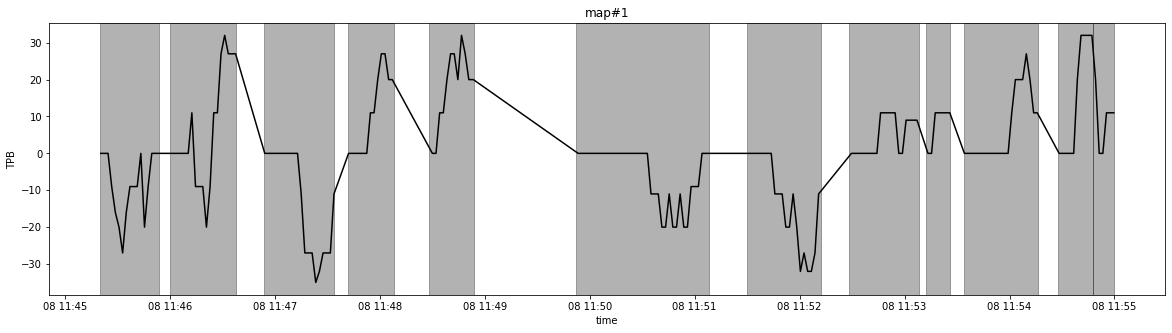

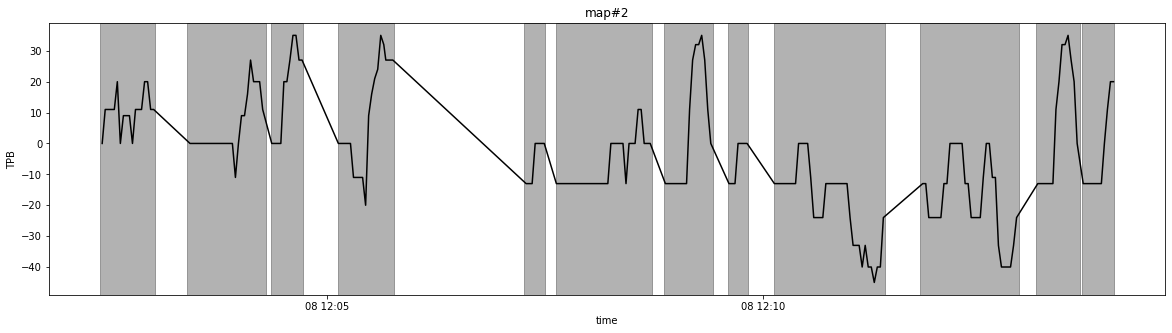

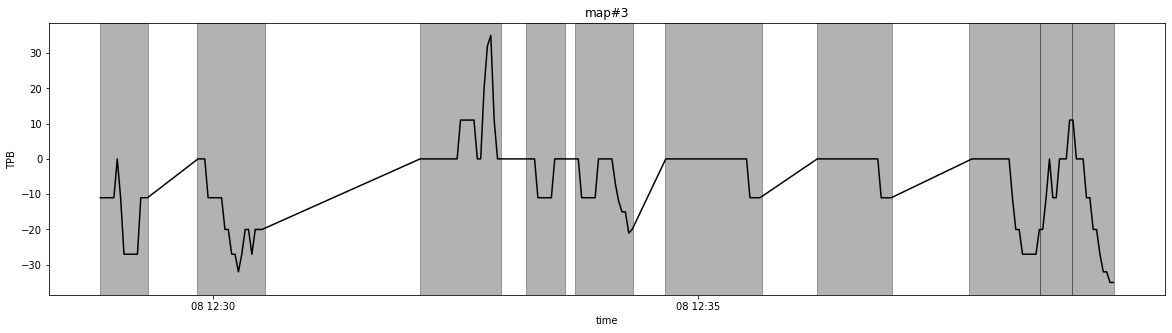

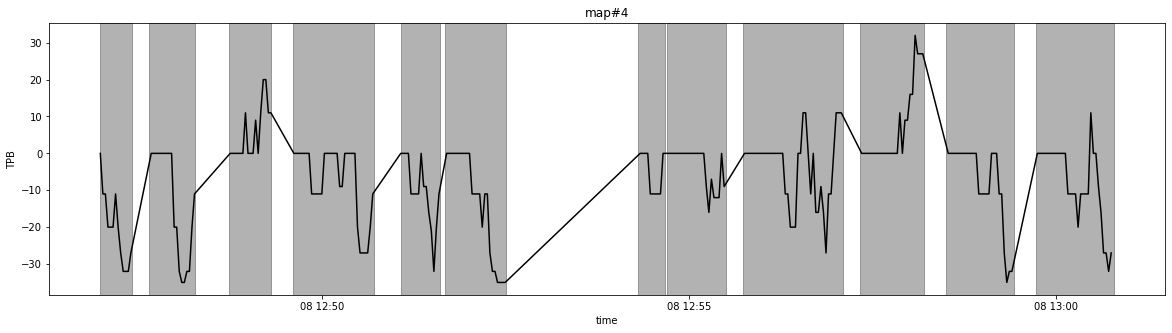

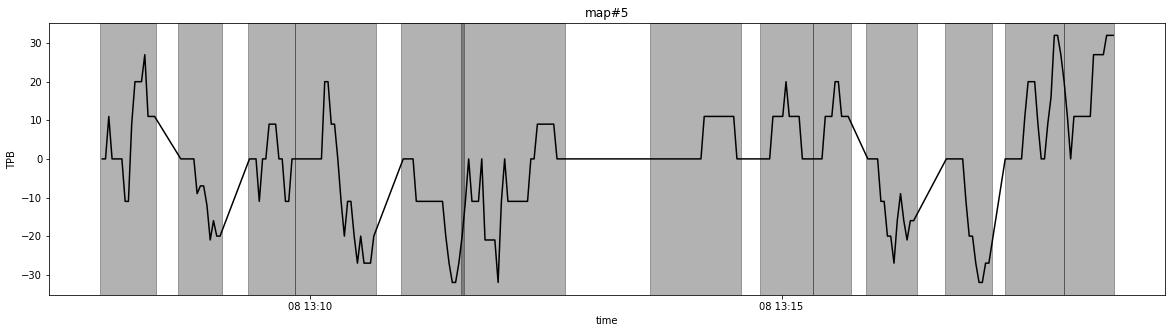

In [32]:
TPB = stat_report.get_TPB()
display(TPB)
TPB_group = TPB.groupby(['map_order', 'map_name', 'TF_order', 'TF_winner', 'TF_duration'])[['TPB']].sum()
display(TPB_group)
TPB_map1_tf1 = TPB[(TPB['map_order'] == 1) & (TPB['TF_order'] == 1)]['TPB'].sum()
print(TPB_map1_tf1)

# plot by map
for num_map in TPB['map_order'].unique():
    plt.figure(figsize=(20,5))
    plt.title(f'map#{num_map}')
    sns.lineplot(x='time', y='TPB', data=TPB[(TPB['map_order'] == num_map)], color='black')
    for idx in stat_report.tf_timeline[stat_report.tf_timeline['map_order'] == num_map].index:
        plt.axvspan(stat_report.tf_timeline.loc[idx, 'TF_start_datetime'], stat_report.tf_timeline.loc[idx, 'TF_end_datetime'], alpha=0.3, color='black')
    plt.show()

# plot by teamfight
# for num_map in TPB['map_order'].unique():
#     for num_TF in TPB['TF_order'].unique():
#         plt.figure(figsize=(20,5))
#         plt.title(f'map#{num_map}_TF#{num_TF}')
#         sns.lineplot(x='time', y='TPB', data=TPB[(TPB['map_order'] == num_map) & (TPB['TF_order'] == num_TF)])
#         plt.show()

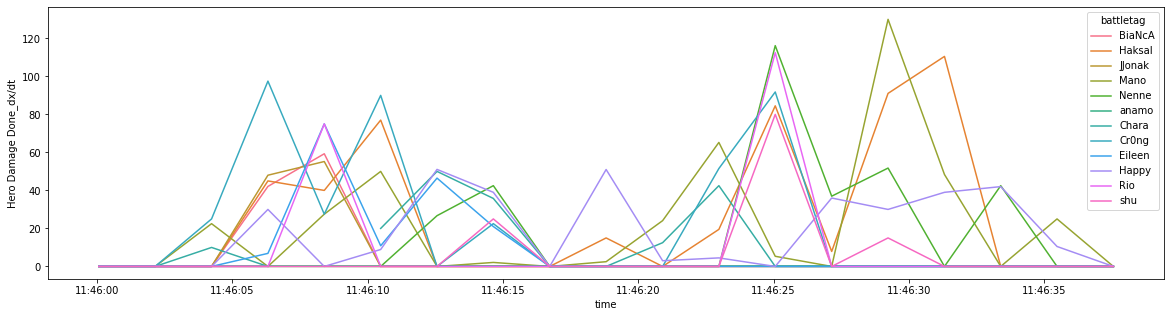

In [34]:
df_tf_trends = stat_report.get_tf_trends()
map1 = df_tf_trends.xs((1, 2, 'All Heroes'), level=['map_order', 'TF_order', 'hero_name'], drop_level=False)
plt.figure(figsize=(20,5))
sns.lineplot(x='time', y='Hero Damage Done_dx/dt', data=map1, hue='battletag')
plt.show()

In [37]:
display(df_tf_trends[['Final Blows', 'Alives_New York Excelsior', 'Alives_Guangzhou Charge', 'TPB', 'TF_duration']])

Final Blows  \
map_order map_name      TF_order TF_winner          time                                esports_team_id battletag hero_name                 
1         Busan         1        Guangzhou Charge   2020-08-08 11:45:20.480999947+00:00 4403.0          BiaNcA    All Heroes          0.0   
                                                                                                                  Zarya               0.0   
                                                                                                        Haksal    All Heroes          1.0   
                                                                                                                  Genji               1.0   
                                                                                                                  Symmetra            0.0   
...                                                                                                                                   ...   
5         Lijiang Tower 13       New York Excelsior 2020-08-08 13:18:31.180000067+00:00 7699.0          Rio       Winston             4.0   
                                                                                                        shu       All Heroes          5.0   
                                                                                                                  Ana                 0.0   
                                                                                                                  Baptiste            0.0   
                                                                                                                  Moira               5.0   

                                                                                                                              Alives_New York Excelsior  \
map_order map_name      TF_order TF_winner          time                                esports_team_id battletag hero_name                               
1         Busan         1        Guangzhou Charge   2020-08-08 11:45:20.480999947+00:00 4403.0          BiaNcA    All Heroes                        5.0   
                                                                                                                  Zarya                             5.0   
                                                                                                        Haksal    All Heroes                        5.0   
                                                                                                                  Genji                             5.0   
                                                                                                                  Symmetra                          5.0   
...                                                                                                                                                 ...   
5         Lijiang Tower 13       New York Excelsior 2020-08-08 13:18:31.180000067+00:00 7699.0          Rio       Winston                           6.0   
                                                                                                        shu       All Heroes                        6.0   
                                                                                                                  Ana                               6.0   
                                                                                                                  Baptiste                          6.0   
                                                                                                                  Moira                             6.0   

                                                                                                                              Alives_Guangzhou Charge  \
map_order map_name      TF_order TF_winner          time                                esports_team_id battletag hero_name

In [ ]:
tf1 = stat_report.get_tf_trends().xs(1, level='map_order')
tf1 = tf1[tf1['TF_order'] == 1].groupby(by=['time', 'esports_team_id']).sum()
plt.figure(figsize=(20,5))
sns.lineplot(x='time', y=0, data=tf1, color='black', alpha=0, linewidth=1, linestyle=':')
sns.lineplot(x='time', y='Final Blows_dx', data=tf1, hue='esports_team_id')
plt.show()

In [ ]:
timeplayed = match.import_esd(short_stat_guid=33)
df = match.import_esd(short_stat_guid=42)

timeplayed = timeplayed.groupby(by=['map_order', 'esports_team_id', 'battletag', 'hero_name'])[['amount']].max()
dashboard = df.groupby(by=['map_order', 'esports_team_id', 'battletag', 'hero_name'])[['amount']].max()
dashboard.rename(columns={'amount':'HR'}, inplace=True)

df_merge = pd.merge(timeplayed, dashboard, how='outer', left_index=True, right_index=True).fillna(0)

display(df_merge)

# dashboard_team_match_agg = dashboard.groupby(by=['esports_team_id'])[['amount']].sum()
# dashboard_player_match_agg = dashboard.groupby(by=['esports_team_id', 'battletag', 'hero_name'])[['amount']].sum()
# display(dashboard_player_match_agg)
# display(dashboard)

In [ ]:
# Teamfight trends
# teamfight dashboard
# HDD, FB, Death, Ult earned, Ult used, TPB, Resources earned after teamfight:{ultimates, objective scores(gameinfo)}
teamfight = Teamfight(match_id=34912)
df_trend = teamfight.get_TF_trends(short_stat_guid=44)

## Save esd_tf to MySQL DB

In [ ]:
# save esd_tf to mysql DB
def export_to_db(esd_tf, dbname="teamfight"):
    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    port = 3306
    # dbname = "teamfight" # schema name to export the df
    charset = "utf8"

    # Create engine
    engine = create_engine('mysql+pymysql://' + username + ':' + pwd + '@' + hostname + ':' + str(port) + '/' + dbname , echo=False)

    # export dataframe into mysql
    table_id = f'match_{match_id}'
    esd_tf.to_sql(name=table_id, con=engine, schema=dbname, if_exists='fail')


## Visualization